In [11]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import GRU, Activation, Dense, Dropout, Input, Embedding,Flatten
from keras import Model
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.backend import clear_session
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer, HashingVectorizer
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SVMSMOTE, SMOTENC,SMOTEN,SMOTE
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from numpy import array
from keras.models import Sequential
from keras import layers


clear_session()
# dataset

df=pd.read_csv('/Users/joe/Desktop/language-models-sprint1/data/train.csv')


#Split the data into train and test sets
X = df['text']
y = df['target']
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



# apply tokonizer
tokenizer = Tokenizer(lower=True,num_words=40000)
tokenizer.fit_on_texts(X_train)
X_train_tok = tokenizer.texts_to_sequences(X_train)


vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

X_test = tokenizer.texts_to_sequences(X_test)

# padding zerros to insure the sequence of words in a text is equal
# the tweet is 280 long, so I set the padding to 
padding_length=280
X_train_tok=pad_sequences(X_train_tok,padding='post',maxlen=padding_length)
X_test=pad_sequences(X_test,padding='post',maxlen=padding_length)


#early stopping 
early_stop=EarlyStopping(monitor='val_loss',patience=1, mode='min', verbose=1)

embedding_dim=20


''' Defining all the layers in an the recurrent neural network (GRU)'''
def GRUs():
    inputs= (Input(name='inputs',shape=[padding_length]))
    layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_length)(inputs)
    layer = Bidirectional(GRU(30, activation='tanh',recurrent_dropout=0.20))(layer)
    layer = Dense(85, activation='relu')(layer)
    layer = Dropout(0.10)(layer)
    layer = Flatten()(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = GRUs()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

# fit the model
history=model.fit(X_train_tok,y_train,
                  batch_size=800,epochs=60,verbose=1,validation_split=0.05,callbacks=[early_stop])

loss, accuracy = model.evaluate(X_train_tok, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 280)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 280, 20)           373040    
_________________________________________________________________
bidirectional (Bidirectional (None, 60)                9360      
_________________________________________________________________
dense (Dense)                (None, 85)                5185      
_________________________________________________________________
dropout (Dropout)            (None, 85)                0         
_________________________________________________________________
flatten (Flatten)            (None, 85)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 86    

In [5]:
#Function to plot the result

plt.style.use('ggplot')

def plot_accuracy_loss(model):

    training_accuracy = model.history['accuracy']
    validation_accuracy = model.history['val_accuracy']
    training_loss = model.history['loss']
    validation_loss = model.history['val_loss']
    x = range(1, len(training_accuracy) + 1)

    plt.figure(figsize=(15, 6),facecolor='w')
    plt.subplot(1, 2, 1)
    plt.plot(x, training_accuracy, 'g', label='Training Accuracy')
    plt.plot(x, validation_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, training_loss, 'g', label='Training Loss')
    plt.plot(x, validation_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss (%) ')
    plt.legend()

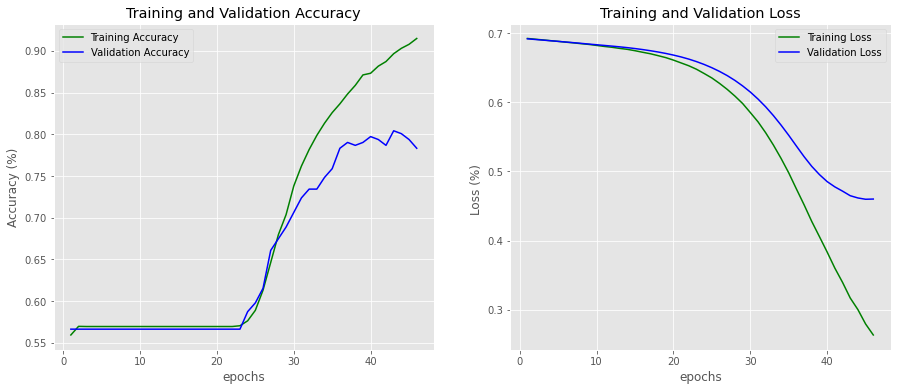

In [12]:
plot_accuracy_loss(history)